<a href="https://colab.research.google.com/github/soph-ma/amazon_database_analysis/blob/main/fake_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import csv
import nltk
import json
import random

from nltk.corpus import stopwords
from tensorflow import keras
from keras.layers import Dropout
from keras import preprocessing
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
f_hand = open("fake_reviews_dataset.csv")
csvreader = csv.reader(f_hand)

header = next(csvreader)

rows = []
for row in csvreader:
  rows.append(row)

# Preprocessing

In [ ]:
# save labels and reviews in separate lists
reviews = [rev[3] for rev in rows]   
labels = [rev[2] for rev in rows]

print(reviews[:10])

['Love this!  Well made, sturdy, and very comfortable.  I love it!Very pretty', "love it, a great upgrade from the original.  I've had mine for a couple of years", 'This pillow saved my back. I love the look and feel of this pillow.', 'Missing information on how to use it, but it is a great product for the price!  I', 'Very nice set. Good quality. We have had the set for two months now and have not been', 'I WANTED DIFFERENT FLAVORS BUT THEY ARE NOT.', 'They are the perfect touch for me and the only thing I wish they had a little more space.', 'These done fit well and look great.  I love the smoothness of the edges and the extra', "Great big numbers & easy to read, the only thing I didn't like is the size of the", 'My son loves this comforter and it is very well made.  We also have a baby']


In [ ]:
# lowercase and remove stopwords
all_reviews = []                                    # a list of lists where each list is a separate review
def get_data(reviews=reviews):                        
  for review in reviews:

    stop_words = stopwords.words('english')
    review = [w.lower() for w in review.split() if w not in stop_words and w.isalpha()]  
    all_reviews.append(review)

In [ ]:
get_data(reviews)

In [ ]:
print(all_reviews[:5])
print(len(all_reviews))

[['love', 'well', 'i', 'love', 'pretty'], ['love', 'great', 'upgrade', 'mine', 'couple', 'years'], ['this', 'pillow', 'saved', 'i', 'love', 'look', 'feel'], ['missing', 'information', 'use', 'great', 'product', 'i'], ['very', 'nice', 'good', 'we', 'set', 'two', 'months']]
40432


In [ ]:
# create word index
def create_index(filename, all_reviews=all_reviews):
  tokenizer = Tokenizer(num_words=100000) 

  words = []
  for rev in all_reviews:
    for word in rev:
      words.append(word)
  tokenizer.fit_on_texts(words) 
  sequences = tokenizer.texts_to_sequences(words)
  word_index = tokenizer.word_index
  print(f"Found {len(word_index)} unique words")

  with open (filename, 'w') as f:
        json.dump(word_index, f, indent=4)

In [ ]:
create_index("word_index.json", all_reviews)

Found 33155 unique words


In [ ]:
#grab and return word index
def get_index(filename): 
    with open(filename, 'r') as f:
        data = json.load(f)
    return(data)

In [ ]:
word_index = get_index('word_index.json')

In [ ]:
def padding_data(sentences, index, maxlen=25):
  new_sentences = []
  for sentence in sentences:                     # in our case for sentence in all_reviews
    new_sentence = []
    words = []
    for word in sentence:
      try:
        word = index[word]
      except:
        KeyError
        word = 0
      words.append(word)  # append words converted to numbers
    new_sentence.append(words)
    new_sentence = preprocessing.sequence.pad_sequences(new_sentence, maxlen=maxlen, padding='post')
    new_sentences.append(new_sentence[0])
  return new_sentences

In [ ]:
padded = padding_data(all_reviews, word_index, maxlen=25)
print(padded[:2])

[array([ 8, 13,  1,  8, 73,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0], dtype=int32), array([   8,    3, 1909,  571,   99,  125,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0], dtype=int32)]


In [ ]:
# reverse word index
def reverse_index(word_index):
    reverse_word_index = {value: key for (key, value) in word_index.items()}
    return(reverse_word_index)
    
def reconst_text(padded_revs, reverse_word_index):
    return(" ".join([reverse_word_index.get(i, "?") for i in padded_revs]))

In [ ]:
reverse_word_index = reverse_index(word_index)

reconst_text(padded[0], reverse_word_index)

'love well i love pretty ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?'

# Labelling

In [ ]:
def convert_labels(lbls):
  converted_labels = []
  for label in lbls:
    if label == "CG":
      converted_labels.append(1)
    else:
      converted_labels.append(0)
  return converted_labels

In [ ]:
convert_lbls = convert_labels(labels)


In [ ]:
def label_data(sentences, labels):
  total_chunks = []
  for sent, lbl in zip(sentences, labels):
    chunk = (sent, lbl)
    total_chunks.append(chunk)
  return total_chunks

In [ ]:
labelled = label_data(padded, convert_lbls)
print(labelled[0])

(array([ 8, 13,  1,  8, 73,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0], dtype=int32), 1)


# Split data into training and testing

In [ ]:
X = np.array(padded)
y = np.array(convert_lbls)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, test_size=0.2, random_state=100)

# Create model

**Logistic regression**

In [ ]:
# create model
def create_logreg():
  model = keras.Sequential()
  model.add(keras.layers.Dense(32, input_shape=(25,), activation="sigmoid"))
  model.summary()
  model.compile(optimizer="adam", loss='squared_hinge', metrics=['accuracy'])
  return(model)

In [ ]:
model = create_logreg()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 32)                832       
                                                                 
Total params: 832
Trainable params: 832
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def train_model(model, x_train, y_train, x_test, y_test, 
                val_size=.1, epochs=1, batch_size=32):
  vals = int(len(labelled)*val_size)
  x_val = x_train[:vals]
  x_train = x_train[vals:]
  y_val = y_train[:vals]
  y_train = y_train[vals:]
  
  history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val), verbose=1, shuffle=True)

  plt.plot(history.history['loss'], label='MAE (training data)')
  plt.plot(history.history['val_loss'], label='MAE (validation data)')
  plt.title('MAE logistic regression')
  plt.ylabel('MAE value')
  plt.xlabel('No. epoch')
  plt.legend(loc="upper left")
  plt.show()

  model_results = model.evaluate(x_test, y_test)
  return model

Epoch 1/50
885/885 [==============================] - 2s 2ms/step - loss: 1.0096 - accuracy: 0.4030 - val_loss: 1.0060 - val_accuracy: 0.4076
Epoch 2/50
885/885 [==============================] - 2s 2ms/step - loss: 1.0084 - accuracy: 0.4121 - val_loss: 1.0045 - val_accuracy: 0.4291
Epoch 3/50
885/885 [==============================] - 2s 2ms/step - loss: 1.0080 - accuracy: 0.4141 - val_loss: 1.0049 - val_accuracy: 0.4064
Epoch 4/50
885/885 [==============================] - 2s 2ms/step - loss: 1.0082 - accuracy: 0.3998 - val_loss: 1.0056 - val_accuracy: 0.4000
Epoch 5/50
885/885 [==============================] - 2s 2ms/step - loss: 1.0082 - accuracy: 0.4010 - val_loss: 1.0059 - val_accuracy: 0.4002
Epoch 6/50
885/885 [==============================] - 2s 2ms/step - loss: 1.0097 - accuracy: 0.3884 - val_loss: 1.0067 - val_accuracy: 0.4056
Epoch 7/50
885/885 [==============================] - 2s 2ms/step - loss: 1.0099 - accuracy: 0.4197 - val_loss: 1.0056 - val_accuracy: 0.4405
Epoch 

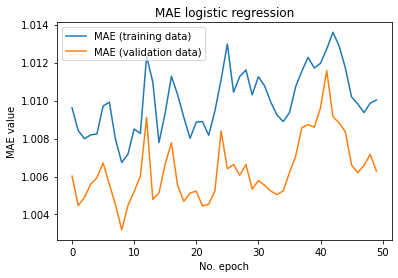

253/253 [==============================] - 0s 2ms/step - loss: 1.0086 - accuracy: 0.3932


In [ ]:
model = train_model(model, x_train=X_train, y_train=y_train, x_test=X_test, y_test=y_test, epochs=50, batch_size=32)

**DNN**

In [ ]:
#create model
def create_dnn():
  model = keras.Sequential()
  model.add(keras.layers.Embedding(100000, 25))
  model.add(keras.layers.GlobalAveragePooling1D())
  model.add(keras.layers.Dense(32, activation='relu'))
  model.add(Dropout(0.3))
  model.add(keras.layers.Dense(32, activation='relu'))
  model.add(Dropout(0.2))
  model.add(keras.layers.Dense(16, activation='relu'))
  model.add(Dropout(0.2))
  model.add(keras.layers.Dense(1, activation='sigmoid',))
  model.summary()
  model.compile(optimizer='adam', loss='squared_hinge', metrics=['accuracy'])
  return(model)

In [ ]:
model2 = create_dnn()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 25)          2500000   
                                                                 
 global_average_pooling1d (G  (None, 25)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 32)                832       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                        

In [ ]:
def train_model2(model, x_train, y_train, x_test, y_test, 
                val_size=.1, epochs=1, batch_size=32):
  vals = int(len(labelled)*val_size)
  x_val = x_train[:vals]
  x_train = x_train[vals:]
  y_val = y_train[:vals]
  y_train = y_train[vals:]
  
  history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val), verbose=1, shuffle=True)

  plt.plot(history.history['loss'], label='MAE (training data)')
  plt.plot(history.history['val_loss'], label='MAE (validation data)')
  plt.title('MAE deep neural network')
  plt.ylabel('MAE value')
  plt.xlabel('No. epoch')
  plt.legend(loc="upper left")
  plt.show()

  model_results = model.evaluate(x_test, y_test)
  return model

Epoch 1/20
885/885 [==============================] - 32s 36ms/step - loss: 0.7948 - accuracy: 0.7385 - val_loss: 0.6813 - val_accuracy: 0.8437
Epoch 2/20
885/885 [==============================] - 39s 44ms/step - loss: 0.6640 - accuracy: 0.8627 - val_loss: 0.6735 - val_accuracy: 0.8580
Epoch 3/20
885/885 [==============================] - 28s 32ms/step - loss: 0.6377 - accuracy: 0.8870 - val_loss: 0.6890 - val_accuracy: 0.8679
Epoch 4/20
885/885 [==============================] - 27s 31ms/step - loss: 0.6223 - accuracy: 0.8988 - val_loss: 0.6914 - val_accuracy: 0.8489
Epoch 5/20
885/885 [==============================] - 28s 31ms/step - loss: 0.6131 - accuracy: 0.9073 - val_loss: 0.6877 - val_accuracy: 0.8645
Epoch 6/20
885/885 [==============================] - 27s 31ms/step - loss: 0.6083 - accuracy: 0.9121 - val_loss: 0.6866 - val_accuracy: 0.8593
Epoch 7/20
885/885 [==============================] - 27s 30ms/step - loss: 0.5996 - accuracy: 0.9182 - val_loss: 0.6880 - val_accuracy:

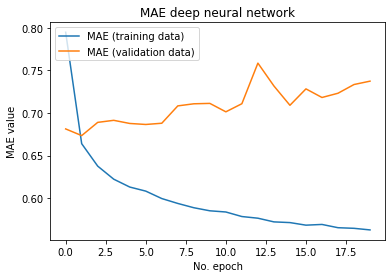

253/253 [==============================] - 0s 2ms/step - loss: 0.7293 - accuracy: 0.8535


In [ ]:
model = train_model2(model2, x_train=X_train, y_train=y_train, x_test=X_test, y_test=y_test, epochs=20, batch_size=32)

In [ ]:
model.save('models/fake_real.model')

INFO:tensorflow:Assets written to: models/fake_real.model/assets
